In [1]:
root_dir = '..' 

import os, sys, datetime, re
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(join(root_dir,'cvtracer2'))
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.Group import Group
from cvt.TrAQ.CVTracer import CVTracer

raw_dir      = join(root_dir,'data')
tracking_dir = join(root_dir,'tracking')

In [2]:
''' Pick a raw video to process. '''

video_files = glob(join(raw_dir,'*.avi'))
# print(video_files)

input_file  = video_files[1]
print(input_file)

../data/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000.avi


In [3]:
''' Extract trial info from the filename and video itself. '''

filename,ext           = os.path.splitext(os.path.basename(input_file))
pop,_,age,group,Nfish,date = filename.split('_')
Nfish = int(re.findall('\d+',Nfish)[0])
date  = ''.join(date.split('-')[:3])
trial_info = { k:globals()[k] for k in ['ext','filename','pop','age','group','Nfish','date'] }

cap = cv2.VideoCapture(input_file)
cap.read()
trial_info['Nframes']  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
trial_info['fps']      = int(cap.get(cv2.CAP_PROP_FPS))
trial_info['fourcc']   = int(cap.get(cv2.CAP_PROP_FOURCC))
trial_info['width']    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
trial_info['height']   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

globals().update(trial_info)
trial_info

{'ext': '.avi',
 'filename': 'Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000',
 'pop': 'Pa',
 'age': '7dpf',
 'group': 'GroupA',
 'Nfish': 2,
 'date': '20200605',
 'Nframes': 38143,
 'fps': 30,
 'fourcc': 1196444237,
 'width': 1920,
 'height': 1200}

In [4]:
''' Define and create necessary folders/files/links. '''

output_dir = join(tracking_dir,filename)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

new_input_file = join(output_dir,'raw'+ext)
if not os.path.exists(new_input_file):
    os.symlink(os.path.relpath(input_file,output_dir),new_input_file)
    
bkg_file  = join(output_dir,'background.npy')
tank_file = join(output_dir,'tank.pik')

In [5]:
''' Pick tracking parameters. '''

# General.
t_start,t_end = 60,70 # Times between which to track, in seconds.
window_size = 800,800 # Size of preview windows, in pixels.

# Tank.
tank_radius  = 10     # Radius of the tank, in centimeters.

# Background subtraction.
bkg_frame_skip = 50   # Using every frame of the video to compute the background takes a while.
                      # Instead we only use one frame in bkg_frame_skip.
bkg_sub_amp = 4       # Amplification factor applied after background subtraction.

# Contour detection.
n_pixel_blur  =  3 # square-root of n-pixels for threshold blurring
block_size    = 15 # contour block size
thresh_offset = 3 # threshold offset for contour-finding
min_area =  20 # minimum area for threhold detection
max_area = 500 # maximum area for threhold detection
RGB = True # track in color, false does greyscale

#=========================================

frame_start,frame_end = int(t_start*fps),int(t_end*fps)

tracking_info = { k:globals()[k] for k in ['bkg_file','tank_file','frame_start','frame_end',
                                           'tank_radius','bkg_frame_skip','bkg_sub_amp',
                                           'n_pixel_blur','block_size','thresh_offset',
                                           'min_area','max_area','RGB'] }
tracking_info

{'bkg_file': '../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/background.npy',
 'tank_file': '../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik',
 'frame_start': 1800,
 'frame_end': 2100,
 'tank_radius': 10,
 'bkg_frame_skip': 50,
 'bkg_sub_amp': 4,
 'n_pixel_blur': 3,
 'block_size': 15,
 'thresh_offset': 3,
 'min_area': 20,
 'max_area': 500,
 'RGB': True}

# 1. Locate the tank

In [6]:
tank = Tank(new_input_file,tank_radius)
if os.path.exists(tank_file):
    tank.load(tank_file)
else:
    tank.locate()


        Tank object loaded from ../tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/tank.pik 


# 2. Set up simple background subtraction

## 2.1. Compute the background

Compute the background by averaging frames over the entire video.

In [7]:
if os.path.exists(bkg_file):
    bkg  = np.load(bkg_file)
else:
    t0    = datetime.datetime.now()
    cap   = cv2.VideoCapture(new_input_file)
    _,frame = cap.read()
    bkg   = np.zeros(frame.shape,dtype=float)
    count = 0
    # If bkg_frame_skip is small (<10) it may be faster to use
    # cap.grab instead of cap.set.
    for n in range(0,Nframes,bkg_frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES,n)
        ret,frame = cap.read()
        bkg      += frame
        count    += 1
    bkg   = bkg / count
    np.save(bkg_file,bkg)
    print(datetime.datetime.now()-t0)

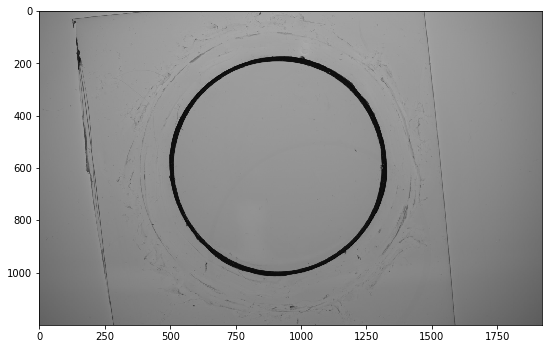

In [8]:
# Show the background.
plt.figure(figsize=(9,9))
plt.imshow(bkg.astype(np.uint))
plt.show()

## 2.2. Preview simple background subtraction

In [9]:
def subtract_background(frame,bkg=bkg,bkg_sub_amp=bkg_sub_amp):
    return 255-np.minimum(255,bkg_sub_amp*np.absolute(frame-bkg)).astype(np.uint8)

def subtract_background(frame,bkg=bkg,bkg_sub_amp=bkg_sub_amp):
    return 255-np.minimum(255,bkg_sub_amp*np.absolute(frame-bkg)).astype(np.uint8)

n_skip = 100 # frame skipping rate

window_name = 'background subtraction preview'
cv2.namedWindow(window_name,cv2.WINDOW_NORMAL)
cv2.moveWindow(window_name,0,0)
cv2.resizeWindow(window_name,window_size[0],window_size[1])

cap = cv2.VideoCapture(new_input_file)
n   = 0
while True:
#     for i in range(n_skip):
#         cap.grab()
    n += n_skip
    cap.set(cv2.CAP_PROP_POS_FRAMES,n)
    ret,frame = cap.read()
    if not ret:
        break
    diff = subtract_background(frame)
#     diff = cv2.GaussianBlur(diff,(5,)*2,0)
    cv2.imshow(window_name,diff)
    k = cv2.waitKey(10)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

# 3. Preview bare contour detection

# 4. Track

## 4.1. No background subtraction

In [10]:
# frame_start,frame_end = 100,160

# bkg_sub_amp   = 4    # Amplification factor applied after background subtraction.
n_pixel_blur  = 5    # square-root of n-pixels for threshold blurring
block_size    = 15   # contour block size
thresh_offset = 4    # threshold offset for contour-finding
min_area      = 50   # minimum area for threhold detection
max_area      = 100  # maximum area for threhold detection

online_viewer = True # False # 

trial = Trial(fvideo=new_input_file, n=Nfish, t=pop, date=date, fps=fps, 
              tank_radius=tank_radius, t_start=t_start, t_end=t_end, reorganize=False)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, online=online_viewer)

cvt.set_frame(cvt.frame_start)
for i_frame in range(cvt.frame_start, cvt.frame_end+1):
    if cvt.get_frame():
#         cvt.frame = subtract_background(cvt.frame,bkg_sub_amp=bkg_sub_amp)
        cvt.mask_tank()
        cvt.detect_contours()
        cvt.analyze_contours()
        cvt.connect_frames()
        cvt.update_trial()
        cvt.draw()
        cvt.write_frame()
#         if cvt.online_viewer:
#             cvt.draw_contours()
        if not cvt.post_frame():
            break
        cvt.print_current_frame()
cvt.release()
cvt.trial.save()


        Trial loaded from /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
2 individuals in trial
4
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:01:40 
       Video capture released.

        Trial object saved as /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


True

In [11]:
# cvt.release()

## 4.2. Simple background subtraction

Uses the average frame computed earlier.

In [12]:
# frame_start,frame_end = 100,160

bkg_sub_amp   = 4    # Amplification factor applied after background subtraction.
n_pixel_blur  = 7    # square-root of n-pixels for threshold blurring
block_size    = 15   # contour block size
thresh_offset = 20   # threshold offset for contour-finding
min_area      = 20   # minimum area for threhold detection
max_area      = 90   # maximum area for threhold detection

online_viewer = True # False # 

trial = Trial(fvideo=new_input_file, n=Nfish, t=pop, date=date, fps=fps, 
              tank_radius=tank_radius, t_start=t_start, t_end=t_end, reorganize=False)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, online=online_viewer)

cvt.set_frame(cvt.frame_start)
for i_frame in range(cvt.frame_start, cvt.frame_end+1):
    if cvt.get_frame():
        cvt.frame = subtract_background(cvt.frame,bkg_sub_amp=bkg_sub_amp)
        cvt.mask_tank()
        cvt.detect_contours()
        cvt.analyze_contours()
        cvt.connect_frames()
        cvt.update_trial()
        cvt.draw()
        cvt.write_frame()
#         if cvt.online_viewer:
#             cvt.draw_contours()
        if not cvt.post_frame():
            break
        cvt.print_current_frame()
cvt.release()
cvt.trial.save()


        Trial loaded from /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
2 individuals in trial
20
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:01:23 
       Video capture released.

        Trial object saved as /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


True

In [13]:
# cvt.release()

## 4.3. MOG2 background subtraction

Uses openCV's MOG2 algorithm. Added to cvtracer by Adam for the dark astyanax schooling trials.

In [14]:
# frame_start,frame_end = 100,160

# bkg_sub_amp   = 4    # Amplification factor applied after background subtraction.
n_pixel_blur  = 3    # square-root of n-pixels for threshold blurring
block_size    = 15   # contour block size
thresh_offset = 4   # threshold offset for contour-finding
min_area      = 15   # minimum area for threhold detection
max_area      = 150   # maximum area for threhold detection

online_viewer = True # False # 

trial = Trial(fvideo=new_input_file, n=Nfish, t=pop, date=date, fps=fps, 
              tank_radius=tank_radius, t_start=t_start, t_end=t_end, reorganize=False)

cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
               threshold_offset=thresh_offset, min_area=min_area, view_scale=1, RGB=True,
               frame_start=frame_start, frame_end=frame_end, online=online_viewer, 
               MOG2=True)

cvt.set_frame(cvt.frame_start)
for i_frame in range(cvt.frame_start, cvt.frame_end+1):
    if cvt.get_frame():
        cvt.mask_tank()
        cvt.mask_background()
        cvt.detect_contours()
        cvt.analyze_contours()
        cvt.connect_frames()
        cvt.update_trial()
        cvt.draw()
        cvt.write_frame()
#         if cvt.online_viewer:
#             cvt.draw_contours()
        if not cvt.post_frame():
            break
        cvt.print_current_frame()
cvt.release()
cvt.trial.save()


        Trial loaded from /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 
2 individuals in trial
Using MOG2 Background Subtraction
4
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
 Group of 2
       Current tracking time: 00:01:01:20 
       Video capture released.

        Trial object saved as /media/data2/work/research/larval_schooling/tracking/Pa_Fri_7dpf_GroupA_n2b_2020-06-05-103456-0000/trial.pik 


True

In [15]:
cvt.release()


       Video capture released.
